# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups              
Sample_056  P02745                         19.792
Sample_138  A0A087WYL5;Q6UXD5-3;Q6UXD5-5   19.162
Sample_027  A0A087WUT8;O95196;O95196-2     18.335
Sample_148  P60709;P63261                  19.064
Sample_057  P06307                         18.165
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_108  O95881           10.483
Sample_118  P02792           15.517
Sample_055  P07711           17.248
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.171
            A0A075B6Q5                 13.716
            A0A075B6R2                 13.395
            A0A075B6S5                 12.915
            A0A087WSY4                 13.840
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.097
            Q9UI40;Q9UI40-2            13.032
            Q9UIW2                     12.017
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.246
            Q9UP79                     12.266
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.940,15.050,16.842,19.863,15.762,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.845,19.067,...,15.528,15.576,13.943,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.971,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.626,17.705,17.039,16.383,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.779,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.456,15.345,17.084,18.708,14.249,19.433,11.301,11.324
Sample_207,15.739,16.877,15.469,16.898,14.984,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.953,13.924,13.261,12.336,12.696,11.658,11.878,13.425,13.542,12.318
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.180,19.067,16.127,...,13.339,13.276,11.960,13.509,13.557,12.785,12.612,12.606,11.905,12.240
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.598,13.501,14.200,13.581,13.321,11.734,13.379,12.724,12.259,12.810
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.921,12.088,12.714,12.269,11.659,12.712,12.232,11.376,12.784,13.307
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.742,13.727,13.879,12.288,13.489,14.094,11.299,12.034,12.489,13.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.801,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 348.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.71it/s]

100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

100%|██████████| 3/3 [00:00<00:00,  7.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

100%|██████████| 4/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.34it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.98it/s]

100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.05it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.42it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.43it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.37it/s]

100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.38it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.24it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.61it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.86it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.17it/s]

100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.92it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.61it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.67it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.49it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.09it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.19it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.48it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.85it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.45it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.20it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.29it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.62it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.29it/s]

 40%|████      | 4/10 [00:00<00:00,  6.06it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.46it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.03it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.05it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.93it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.58it/s]

100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 13.23it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.64it/s]

 45%|████▌     | 5/11 [00:00<00:00,  8.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.56it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.58it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  7.40it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  7.36it/s]

 91%|█████████ | 10/11 [00:01<00:00,  7.36it/s]

100%|██████████| 11/11 [00:01<00:00,  7.34it/s]

100%|██████████| 11/11 [00:01<00:00,  7.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.67it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.02it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.31it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.03it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.86it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.56it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.44it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.01it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.37it/s]

100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

100%|██████████| 12/12 [00:01<00:00,  6.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 13.10it/s]

 31%|███       | 4/13 [00:00<00:01,  7.32it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.57it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.45it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.41it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.22it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.01it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.74it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.73it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.90it/s]

100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.60it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.13it/s]

 36%|███▌      | 5/14 [00:00<00:01,  8.56it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.21it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.16it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.80it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.60it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.59it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.48it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.30it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.36it/s]

100%|██████████| 14/14 [00:01<00:00,  6.78it/s]

100%|██████████| 14/14 [00:01<00:00,  7.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 14.27it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.06it/s]

 40%|████      | 6/15 [00:00<00:01,  7.79it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.30it/s]

 53%|█████▎    | 8/15 [00:01<00:00,  7.35it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.91it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.12it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.40it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.72it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.92it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  6.96it/s]

100%|██████████| 15/15 [00:02<00:00,  7.12it/s]

100%|██████████| 15/15 [00:02<00:00,  7.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.043 0.016          0.854 0.240       0.149   
2             0.004 0.003      0.044 0.014          0.724 0.213       0.246   
3             0.002 0.000      0.019 0.001          0.684 0.146       0.400   
4             0.003 0.002      0.034 0.016          0.756 0.103       0.735   
5             0.004 0.002      0.043 0.016          0.792 0.089       0.767   
6             0.004 0.003      0.040 0.013          0.793 0.093       0.767   
7             0.003 0.001      0.030 0.006          0.800 0.094       0.766   
8             0.003 0.000      0.037 0.012          0.845 0.085       0.804   
9             0.004 0.003      0.037 0.012          0.844 0.091       0.807   
10            0.004 0.003      0.040 0.015          0.852 0.086       0.839   
11            0.003 0.002      0.032 0.016          0.845 0.079       0.837   
12            0.002 0.001      0.024 0.013          0.845 0.084       0.831   
13            0.002 0.001      0.023 0.007          0.851 0.074       0.846   
14            0.002 0.000      0.021 0.007          0.849 0.075       0.844   
15            0.002 0.000      0.021 0.004          0.853 0.081       0.842   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.245 0.130                  0.567 0.044        0.857   
2          0.116   0.346 0.129                  0.576 0.065        0.750   
3          0.122   0.487 0.103                  0.623 0.061        0.711   
4          0.103   0.741 0.082                  0.778 0.069        0.883   
5          0.114   0.774 0.079                  0.808 0.064        0.898   
6          0.110   0.774 0.079                  0.808 0.064        0.898   
7          0.106   0.777 0.077                  0.810 0.063        0.897   
8          0.096   0.818 0.062                  0.845 0.050        0.919   
9          0.094   0.819 0.065                  0.845 0.053        0.918   
10         0.078   0.841 0.057                  0.863 0.049        0.919   
11         0.077   0.838 0.057                  0.861 0.049        0.927   
12         0.078   0.834 0.059                  0.857 0.051        0.927   
13         0.078   0.845 0.054                  0.867 0.046        0.929   
14         0.078   0.843 0.056                  0.866 0.048        0.928   
15         0.087   0.844 0.065                  0.867 0.055        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.825 0.084        210.000 0.000  
2          0.107                  0.693 0.130        210.000 0.000  
3          0.098                  0.629 0.115        210.000 0.000  
4          0.053                  0.849 0.072        210.000 0.000  
5          0.050                  0.859 0.073        210.000 0.000  
6          0.048                  0.861 0.069        210.000 0.000  
7          0.048                  0.860 0.070        210.000 0.000  
8          0.045                  0.893 0.062        210.000 0.000  
9          0.046                  0.892 0.062        210.000 0.000  
10         0.043                  0.895 0.059        210.000 0.000  
11         0.042                  0.907 0.048        210.000 0.000  
12         0.041                  0.909 0.047        210.000 0.000  
13         0.038                  0.909 0.045        210.000 0.000  
14         0.038                  0.908 0.045        210.000 0.000  
15         0.038                  0.914 0.041 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 544.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

100%|██████████| 2/2 [00:00<00:00, 12.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 12.68it/s]

100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.63it/s]

100%|██████████| 4/4 [00:00<00:00,  8.33it/s]

100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.74it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.87it/s]

100%|██████████| 5/5 [00:00<00:00,  5.97it/s]

100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.49it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.54it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

100%|██████████| 6/6 [00:00<00:00,  7.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.46it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.30it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.70it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.64it/s]

100%|██████████| 7/7 [00:01<00:00,  6.45it/s]

100%|██████████| 7/7 [00:01<00:00,  6.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.92it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.27it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.20it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.06it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.06it/s]

100%|██████████| 8/8 [00:01<00:00,  6.11it/s]

100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.59it/s]

 33%|███▎      | 3/9 [00:00<00:00,  7.01it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.13it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.62it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.36it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.22it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.09it/s]

100%|██████████| 9/9 [00:01<00:00,  5.02it/s]

100%|██████████| 9/9 [00:01<00:00,  5.53it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.89it/s]

 30%|███       | 3/10 [00:00<00:01,  5.49it/s]

 40%|████      | 4/10 [00:00<00:01,  5.39it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.42it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.21it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.07it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.93it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.81it/s]

100%|██████████| 10/10 [00:01<00:00,  4.97it/s]

100%|██████████| 10/10 [00:01<00:00,  5.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.18it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.92it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.28it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.57it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.69it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.56it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.27it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.09it/s]

100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

100%|██████████| 11/11 [00:01<00:00,  6.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.10it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.59it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.45it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.11it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.86it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.80it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.76it/s]

100%|██████████| 12/12 [00:01<00:00,  8.72it/s]

100%|██████████| 12/12 [00:01<00:00,  9.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.90it/s]

 31%|███       | 4/13 [00:00<00:01,  8.49it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.89it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.16it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.02it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.82it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.58it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.75it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  7.10it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  7.36it/s]

100%|██████████| 13/13 [00:01<00:00,  7.57it/s]

100%|██████████| 13/13 [00:01<00:00,  7.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.08it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.50it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.50it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.14it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.89it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.80it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.79it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.81it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.73it/s]

100%|██████████| 14/14 [00:01<00:00,  8.62it/s]

100%|██████████| 14/14 [00:01<00:00,  9.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.61it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.94it/s]

 40%|████      | 6/15 [00:00<00:00,  9.52it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.11it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.00it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.89it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.67it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.66it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.65it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.64it/s]

100%|██████████| 15/15 [00:01<00:00,  8.64it/s]

100%|██████████| 15/15 [00:01<00:00,  9.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.005          0.013 0.094       0.002   
2             0.002 0.002      0.022 0.008          0.694 0.117       0.539   
3             0.002 0.000      0.020 0.004          0.693 0.099       0.537   
4             0.002 0.001      0.022 0.005          0.761 0.105       0.605   
5             0.002 0.000      0.021 0.004          0.736 0.082       0.674   
6             0.002 0.000      0.021 0.005          0.729 0.076       0.660   
7             0.002 0.001      0.023 0.005          0.733 0.083       0.650   
8             0.002 0.000      0.020 0.002          0.730 0.079       0.654   
9             0.003 0.001      0.028 0.009          0.771 0.084       0.789   
10            0.002 0.001      0.024 0.007          0.774 0.080       0.787   
11            0.002 0.000      0.020 0.002          0.789 0.084       0.790   
12            0.002 0.000      0.020 0.002          0.799 0.081       0.778   
13            0.002 0.000      0.019 0.000          0.797 0.084       0.772   
14            0.002 0.000      0.019 0.000          0.788 0.082       0.769   
15            0.002 0.000      0.019 0.000          0.792 0.074       0.766   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.863   
2          0.132   0.597 0.109                  0.679 0.076        0.742   
3          0.135   0.594 0.099                  0.678 0.066        0.734   
4          0.111   0.667 0.086                  0.731 0.060        0.795   
5          0.107   0.698 0.077                  0.748 0.059        0.802   
6          0.110   0.688 0.080                  0.740 0.057        0.799   
7          0.115   0.683 0.083                  0.738 0.061        0.800   
8          0.114   0.684 0.081                  0.738 0.059        0.800   
9          0.120   0.775 0.081                  0.808 0.067        0.890   
10         0.115   0.774 0.073                  0.808 0.060        0.891   
11         0.124   0.783 0.076                  0.816 0.063        0.900   
12         0.110   0.782 0.069                  0.815 0.056        0.902   
13         0.114   0.778 0.074                  0.813 0.060        0.900   
14         0.117   0.772 0.076                  0.807 0.062        0.899   
15         0.114   0.773 0.072                  0.809 0.058        0.899   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.831 0.087        210.000 0.000  
2          0.076                  0.672 0.096        210.000 0.000  
3          0.073                  0.664 0.092        210.000 0.000  
4          0.068                  0.760 0.089        210.000 0.000  
5          0.066                  0.763 0.091        210.000 0.000  
6          0.067                  0.763 0.091        210.000 0.000  
7          0.071                  0.762 0.094        210.000 0.000  
8          0.069                  0.761 0.092        210.000 0.000  
9          0.051                  0.861 0.063        210.000 0.000  
10         0.051                  0.861 0.061        210.000 0.000  
11         0.048                  0.875 0.057        210.000 0.000  
12         0.049                  0.880 0.057        210.000 0.000  
13         0.048                  0.877 0.057        210.000 0.000  
14         0.047                  0.876 0.055        210.000 0.000  
15         0.047                  0.876 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1429.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 68.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 47.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.21it/s]

100%|██████████| 5/5 [00:00<00:00, 43.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.35it/s]

100%|██████████| 6/6 [00:00<00:00, 42.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.18it/s]

100%|██████████| 7/7 [00:00<00:00, 41.29it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.37it/s]

100%|██████████| 8/8 [00:00<00:00, 40.60it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.45it/s]

100%|██████████| 9/9 [00:00<00:00, 40.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.59it/s]

100%|██████████| 10/10 [00:00<00:00, 39.07it/s]

100%|██████████| 10/10 [00:00<00:00, 39.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.30it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.75it/s]

100%|██████████| 11/11 [00:00<00:00, 39.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.92it/s]

100%|██████████| 12/12 [00:00<00:00, 38.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.38it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.79it/s]

100%|██████████| 13/13 [00:00<00:00, 38.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.33it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.96it/s]

100%|██████████| 14/14 [00:00<00:00, 37.71it/s]

100%|██████████| 14/14 [00:00<00:00, 38.49it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.28it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.92it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.67it/s]

100%|██████████| 15/15 [00:00<00:00, 38.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.556 0.185       0.220   
3             0.002 0.000      0.019 0.000          0.675 0.112       0.559   
4             0.002 0.000      0.019 0.000          0.688 0.103       0.591   
5             0.002 0.000      0.019 0.000          0.683 0.113       0.588   
6             0.002 0.000      0.019 0.000          0.684 0.103       0.625   
7             0.002 0.000      0.019 0.000          0.703 0.093       0.624   
8             0.002 0.000      0.019 0.000          0.713 0.104       0.631   
9             0.002 0.000      0.019 0.000          0.710 0.097       0.625   
10            0.002 0.000      0.019 0.000          0.691 0.096       0.603   
11            0.002 0.000      0.019 0.001          0.691 0.098       0.621   
12            0.002 0.000      0.019 0.000          0.680 0.092       0.611   
13            0.002 0.000      0.019 0.000          0.699 0.086       0.651   
14            0.002 0.000      0.019 0.000          0.688 0.086       0.645   
15            0.002 0.000      0.019 0.000          0.694 0.089       0.648   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.081   0.307 0.101                  0.541 0.054        0.620   
3          0.112   0.605 0.092                  0.679 0.063        0.765   
4          0.114   0.628 0.084                  0.695 0.062        0.778   
5          0.103   0.625 0.083                  0.690 0.064        0.777   
6          0.123   0.646 0.092                  0.704 0.069        0.798   
7          0.113   0.654 0.082                  0.713 0.062        0.810   
8          0.108   0.662 0.083                  0.719 0.063        0.810   
9          0.107   0.658 0.080                  0.716 0.060        0.807   
10         0.118   0.637 0.087                  0.701 0.065        0.808   
11         0.115   0.648 0.087                  0.707 0.066        0.804   
12         0.111   0.637 0.081                  0.698 0.062        0.804   
13         0.118   0.667 0.084                  0.721 0.062        0.812   
14         0.109   0.661 0.081                  0.715 0.062        0.810   
15         0.116   0.664 0.082                  0.718 0.061        0.810   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.692 0.083        210.000 0.000  
2          0.070                  0.568 0.069        210.000 0.000  
3          0.072                  0.720 0.087        210.000 0.000  
4          0.073                  0.734 0.088        210.000 0.000  
5          0.070                  0.731 0.082        210.000 0.000  
6          0.065                  0.748 0.082        210.000 0.000  
7          0.059                  0.755 0.083        210.000 0.000  
8          0.061                  0.750 0.085        210.000 0.000  
9          0.059                  0.746 0.079        210.000 0.000  
10         0.057                  0.749 0.079        210.000 0.000  
11         0.058                  0.749 0.078        210.000 0.000  
12         0.057                  0.752 0.080        210.000 0.000  
13         0.059                  0.757 0.082        210.000 0.000  
14         0.060                  0.754 0.083        210.000 0.000  
15         0.058                  0.751 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,9,15
score_time,2,9,11
test_precision,1,12,8
test_recall,13,11,13
test_f1,13,11,13
test_balanced_accuracy,13,11,13
test_roc_auc,15,12,13
test_average_precision,15,12,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.89it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.65it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.48it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.16it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.99it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.96it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.92it/s]

100%|██████████| 12/12 [00:01<00:00,  8.90it/s]

100%|██████████| 12/12 [00:01<00:00,  9.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.34it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.84it/s]

100%|██████████| 13/13 [00:00<00:00, 38.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.93it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.67it/s]

 40%|████      | 6/15 [00:00<00:00, 11.27it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.62it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.35it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.26it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.11it/s]

100%|██████████| 15/15 [00:01<00:00, 10.66it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


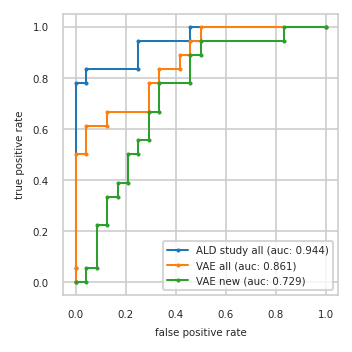

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.778   0.000 0.500   0.042 0.056
3          0.042 0.778   0.042 0.500   0.083 0.056
4          0.042 0.833   0.042 0.611   0.083 0.222
5          0.250 0.833   0.125 0.611   0.125 0.222
6          0.250 0.944   0.125 0.667   0.125 0.333
7          0.458 0.944   0.292 0.667   0.167 0.333
8          0.458 1.000   0.292 0.778   0.167 0.389
9          1.000 1.000   0.333 0.778   0.208 0.389
10           NaN   NaN   0.333 0.833   0.208 0.500
11           NaN   NaN   0.417 0.833   0.250 0.500
12           NaN   NaN   0.417 0.889   0.250 0.556
13           NaN   NaN   0.458 0.889   0.292 0.556
14           NaN   NaN   0.458 0.944   0.292 0.667
15           NaN   NaN   0.500 0.944   0.333 0.667
16           NaN   NaN   0.500 1.000   0.333 0.778
17           NaN   NaN   1.000 1.000   0.458 0.778
18           NaN   NaN     NaN   NaN   0.458 0.889
19           NaN   NaN     NaN   NaN   0.500 0.889
20           NaN   NaN     NaN   NaN   0.500 0.944
21           NaN   NaN     NaN   NaN   0.833 0.944
22           NaN   NaN     NaN   NaN   0.833 1.000
23           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02741,B4DGQ7;P21860;P21860-4,A0A087WXB8;Q9Y274
2,Q12907,E7EUF1;Q13822-3,P51688
3,P09960;P09960-4,P04075,P31321
4,P61981,A0A087WXB8;Q9Y274,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,C9JF17;P05090,Q14894,J3KSJ8;Q9UD71;Q9UD71-2
6,P04075,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P14174,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
8,P00338;P00338-3,P61981,Q9Y281;Q9Y281-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


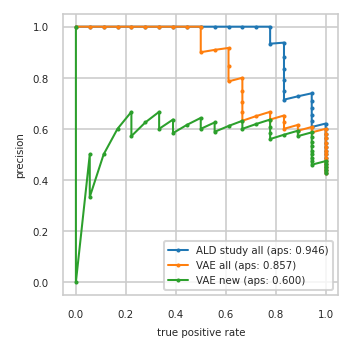

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.593 0.889
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.680 0.944     0.600 0.833     0.560 0.778
18         0.708 0.944     0.625 0.833     0.583 0.778
19         0.739 0.944     0.652 0.833     0.609 0.778
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.632 0.667     0.632 0.667
24         0.833 0.833     0.667 0.667     0.611 0.611
25         0.882 0.833     0.706 0.667     0.588 0.556
26         0.938 0.833     0.750 0.667     0.625 0.556
27         0.933 0.778     0.800 0.667     0.600 0.500
28         1.000 0.778     0.786 0.611     0.643 0.500
29         1.000 0.722     0.846 0.611     0.615 0.444
30         1.000 0.667     0.917 0.611     0.583 0.389
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


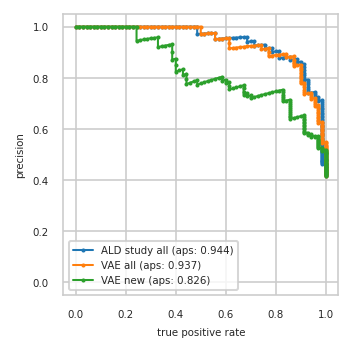

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


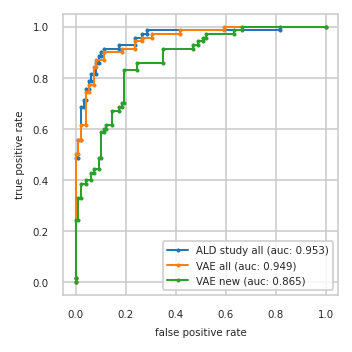

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}